In [7]:
import librosa
import librosa.display
import numpy as np

In [8]:
CNN_INPUT_SIZE = (128, 20)
DEFAULT_SR = 22050

In [9]:
def resize_axis(array, N):
    if(array.shape[1] > N):
        resized = array[:,:N]
    else:
        resized = np.lib.pad(array, ((0,0),(0,N - array.shape[1])),\
            'constant', constant_values=(np.min(array)))
    return resized

In [10]:
def extract_cnn_input(raw_audio):
    frame_length = min(2048, len(raw_audio))
    mel_spec = librosa.core.power_to_db(librosa.feature.melspectrogram(
        y=raw_audio, sr=DEFAULT_SR, n_fft=frame_length,
        hop_length=frame_length//4, n_mels=CNN_INPUT_SIZE[0])
    )
    # Truncate number of frames stored
    m = min(CNN_INPUT_SIZE[1], mel_spec.shape[1])
    N =20
    mell = resize_axis(mel_spec[:, 0:m], N)
    return mell

---

In [11]:
import os

def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [12]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        yt = librosa.util.normalize(yt)
        k = extract_cnn_input(yt)
        k = np.expand_dims(k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

/Users/cooky/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2, random_state=1234, stratify=y_label)

---

In [54]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [55]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 20,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

with tf.device("/gpu:0"):
    history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
 1/14 [=>............................] - ETA: 5s - loss: 4.9084 - accuracy: 0.2188

2022-06-01 15:35:12.965511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 39ms/step - loss: 2.6178 - accuracy: 0.2701 - val_loss: 1.6409 - val_accuracy: 0.4018
Epoch 2/20
 1/14 [=>............................] - ETA: 0s - loss: 1.6476 - accuracy: 0.3438

2022-06-01 15:35:13.500704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 21ms/step - loss: 1.3925 - accuracy: 0.4933 - val_loss: 1.2411 - val_accuracy: 0.5446
Epoch 3/20
14/14 [==============================] - 0s 23ms/step - loss: 1.0118 - accuracy: 0.6540 - val_loss: 0.7153 - val_accuracy: 0.8036
Epoch 4/20
14/14 [==============================] - 0s 24ms/step - loss: 0.7611 - accuracy: 0.7366 - val_loss: 0.6008 - val_accuracy: 0.7857
Epoch 5/20
14/14 [==============================] - 0s 21ms/step - loss: 0.5220 - accuracy: 0.8326 - val_loss: 0.4704 - val_accuracy: 0.8036
Epoch 6/20
14/14 [==============================] - 0s 20ms/step - loss: 0.4553 - accuracy: 0.8527 - val_loss: 0.3752 - val_accuracy: 0.8304
Epoch 7/20
14/14 [==============================] - 0s 20ms/step - loss: 0.3877 - accuracy: 0.8683 - val_loss: 0.3869 - val_accuracy: 0.8304
Epoch 8/20
14/14 [==============================] - 0s 19ms/step - loss: 0.2738 - accuracy: 0.9107 - val_loss: 0.4618 - val_accuracy: 0.8304
Epoch 9/20
14/14 [======

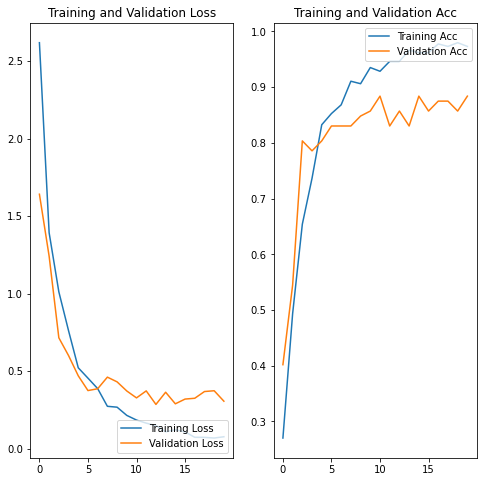

In [57]:
import matplotlib.pyplot as plt

acc = history.history['loss']
val_acc = history.history['val_loss']

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Acc')
plt.plot(epochs_range, val_loss, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')
plt.show()

In [58]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

Y_Lab = np.argmax(y_test, axis = 1)

2022-06-01 15:35:19.340628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [59]:
model.evaluate(x_test,y_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.5353 - accuracy: 0.8857


[0.5352627635002136, 0.8857142925262451]

<AxesSubplot:>

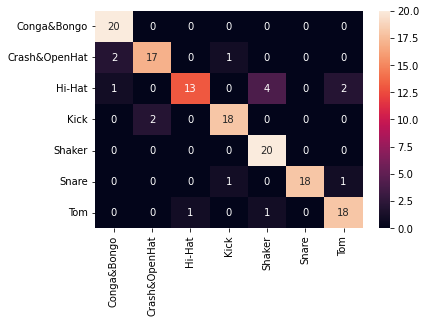

In [60]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(Y_Lab, Y_pred_classes), columns=classes, index=classes)
sns.heatmap(cm, annot=True)